# Распознавание спам-сообщений с помощью классификации

Импортируем все пакеты

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
nltk.download('stopwords')
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загружаем данные

In [42]:
data = pd.read_csv('https://drive.google.com/uc?id=1gz6c3tg0cXHcsXdpyUXRkD-oqKOTYyyH', encoding='windows-1251')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [43]:
data.shape

(5572, 5)

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Удалим три последние колонки, переименуем столбцы и воспользуемся энкодером

In [45]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)
encoder=LabelEncoder()
data['target'] = encoder.fit_transform(data['target'])
data.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Проверка на пустые значения

In [46]:
data.isnull().sum()

,0
target,0
text,0


Проверка на дубликаты

In [47]:
data.duplicated().sum()

403

In [48]:
data = data.drop_duplicates()
data.shape

(5169, 2)

Гистограмма для сравнения хама и спама

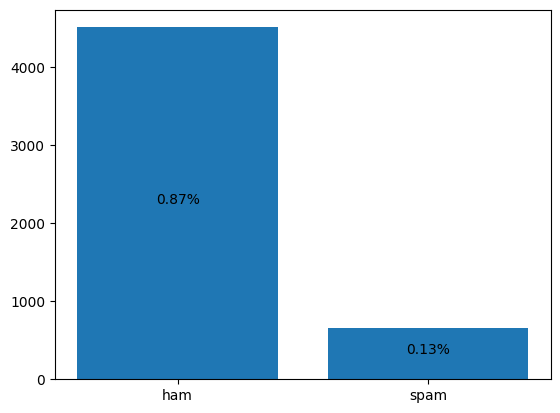

In [49]:
data_plt = pd.DataFrame(data['target'].value_counts())
x = data_plt.index.to_list()
y = data_plt["count"].to_list()
fig, ax = plt.subplots()
pps = ax.bar(x, y)
for p in pps:
   height = round(p.get_height() / sum(y), 2)
   ax.text(x=p.get_x() + p.get_width() / 2, y=p.get_height()/2,
      s="{}%".format(height),
      ha='center')
plt.xticks([0, 1], ['ham','spam'], rotation=0)
plt.show()

Статистика по количеству символов, слов и предложений

In [50]:
data['num_char'] = data['text'].apply(len)
data['num_words'] = data['text'].apply(lambda x:len(nltk.word_tokenize(x)))
data['num_sentences'] = data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
data.head()

,target,text,num_char,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


Обработаем на выбросы правилом трех сигм

In [51]:
def outlier_std(data, col, threshold=3):
  mean = data[col].mean()
  std = data[col].std() # сигма
  up = mean + threshold * std # верхняя грань
  low = mean - threshold * std # нижняя грань

  # все, что за пределами трех сигм - аномалия
  anomalies = pd.concat([data[col] > up, data[col] < low], axis=1).any(axis=1)
  return anomalies, up, low

In [52]:
data_num = data.drop(['text', 'target'], axis=1)
data_cat = data[['text', 'target']]

anomalies, up, low = outlier_std(data_num, data_num.columns)
anomalies

,0
0,False
1,False
2,False
3,False
4,False
...,...
5567,False
5568,False
5569,False
5570,False


In [53]:
def get_column_outliers(data, func=outlier_std, threshold=3):
  # создание столбца - является ли значение выбросом
  outliers = pd.Series(data=[False]*len(data), index=data.index, name='is_outlier')

  comparison_table = {}

  # по каждому признаку
  for column in data.columns:
    anomalies, up, low = func(data, column, threshold=threshold)
    comparison_table[column] = [up, low, sum(anomalies), 100 * sum(anomalies)/len(anomalies)]
    outliers.loc[anomalies[anomalies].index] = True

  comparison_table = pd.DataFrame(comparison_table).T
  comparison_table.columns=['up', 'low', 'anomalies_count', 'anomalies_percentage']
  return comparison_table, outliers

In [54]:
comparison_table, std_outliers = get_column_outliers(data_num)
comparison_table

,up,low,anomalies_count,anomalies_percentage
num_char,253.686825,-95.730934,56.0,1.083382
num_words,58.430068,-21.518480,59.0,1.141420
num_sentences,6.311188,-2.380060,58.0,1.122074


In [55]:
print(f"Total number of outliers: {sum(std_outliers)}\nPercentage of outliers {100 * sum(std_outliers)/len(std_outliers)}")

Total number of outliers: 102
Percentage of outliers 1.9733023795705165


In [56]:
data_num['is_outlier'] = std_outliers
data_num.head()

,num_char,num_words,num_sentences,is_outlier
0,111,24,2,False
1,29,8,2,False
2,155,37,2,False
3,49,13,1,False
4,61,15,1,False


Облака рассеивания по выбросам

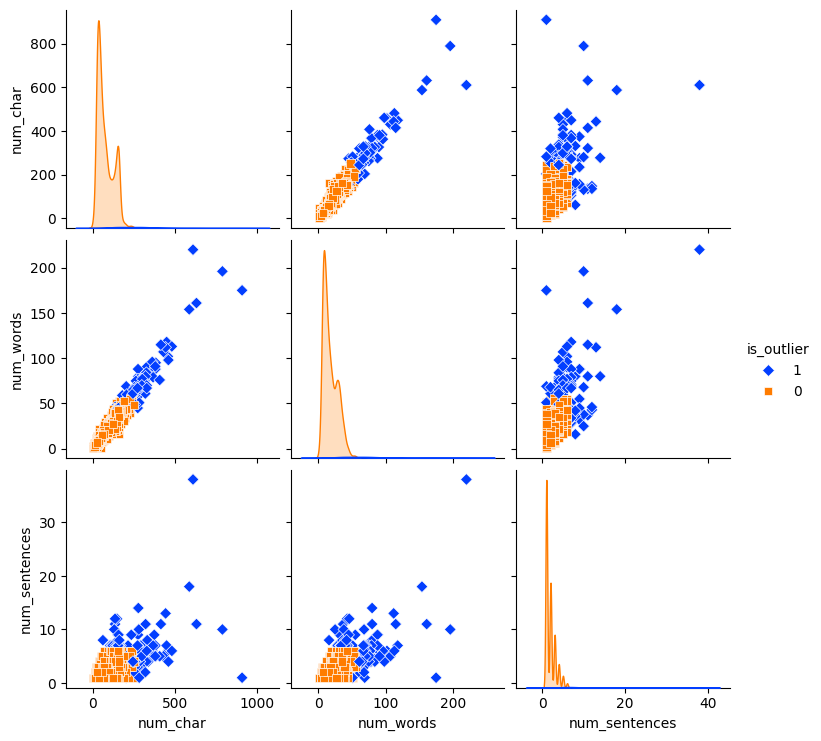

In [57]:
sns.pairplot(data=data_num, vars=data_num.loc[:, data_num.columns != "is_outlier"].columns, hue='is_outlier', hue_order=[1, 0],
             markers=['s', 'D'], palette='bright');

Видно, что выбросы по трем признакам распредлены равномерно. Это соответствует [стаститике.](https://colab.research.google.com/drive/1hITxDF-xXcaPaiv_c6okJvaZV7yRzBSX#scrollTo=O7sdoy3HebVI&line=1&uniqifier=1)

In [58]:
data = pd.concat([data_num, data_cat], axis=1)
data = data.loc[data['is_outlier'] != True]
data = data.drop(['is_outlier'], axis=1)
data

,num_char,num_words,num_sentences,text,target
0,111,24,2,"Go until jurong point, crazy.. Available only ...",0
1,29,8,2,Ok lar... Joking wif u oni...,0
2,155,37,2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,49,13,1,U dun say so early hor... U c already then say...,0
4,61,15,1,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...,...,...
5567,161,35,4,This is the 2nd time we have tried 2 contact u...,1
5568,37,9,1,Will М_ b going to esplanade fr home?,0
5569,57,15,2,"Pity, * was in mood for that. So...any other s...",0
5570,125,27,1,The guy did some bitching but I acted like i'd...,0


Статистика по всему

In [59]:
data[['num_char', 'num_words', 'num_sentences']].describe()

,num_char,num_words,num_sentences
count,5067.000000,5067.000000,5067.000000
mean,75.108545,17.494375,1.865996
std,48.037561,10.455918,1.137767
min,2.000000,1.000000,1.000000
25%,35.000000,9.000000,1.000000
50%,59.000000,14.000000,1.000000
75%,112.000000,25.000000,2.000000
max,251.000000,57.000000,6.000000


Сатистика по спаму

In [60]:
data[data['target'] == 1][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,638.000000,638.000000,638.000000
mean,137.434169,27.492163,2.871473
std,30.331831,6.991075,1.352630
min,13.000000,2.000000,1.000000
25%,131.250000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,6.000000


Статистика по хаму

In [61]:
data[data['target'] == 0][['num_char','num_words','num_sentences']].describe()

,num_char,num_words,num_sentences
count,4429.000000,4429.000000,4429.000000
mean,66.130503,16.054188,1.721156
std,43.213783,10.078228,1.025271
min,2.000000,1.000000,1.000000
25%,33.000000,8.000000,1.000000
50%,51.000000,13.000000,1.000000
75%,87.000000,21.000000,2.000000
max,251.000000,57.000000,6.000000


Визуализация сравниткльной статистики по количеству символов, слов и предложений

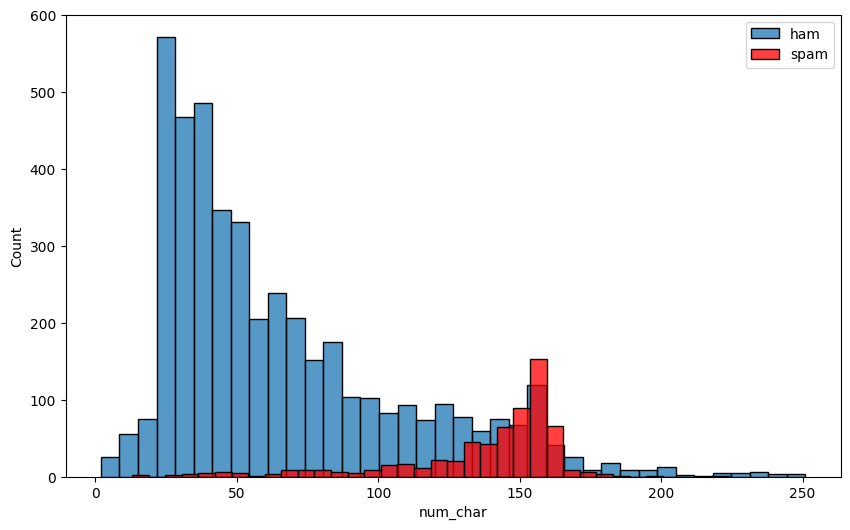

In [62]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data[data['target']==0]['num_char'])
ax = sns.histplot(data[data['target']==1]['num_char'], color='red')
ax.legend(['ham', 'spam'])

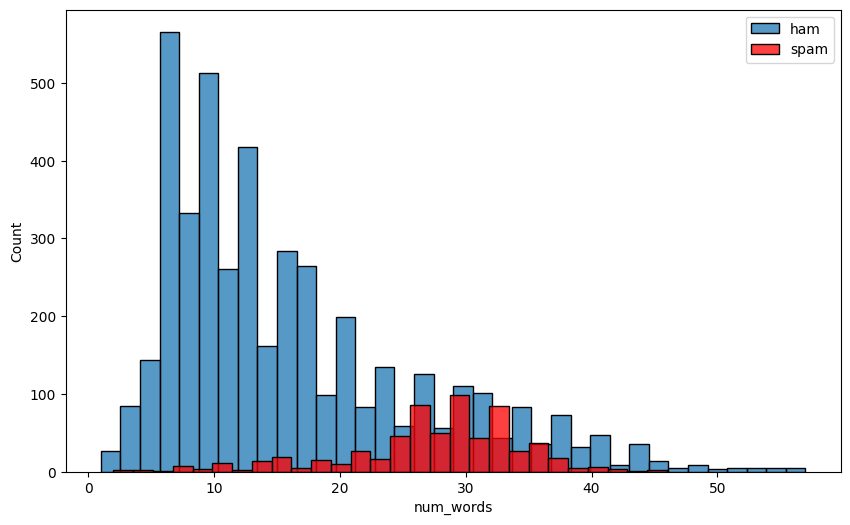

In [63]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data[data['target']==0]['num_words'])
ax = sns.histplot(data[data['target']==1]['num_words'], color='red')
ax.legend(['ham', 'spam'])

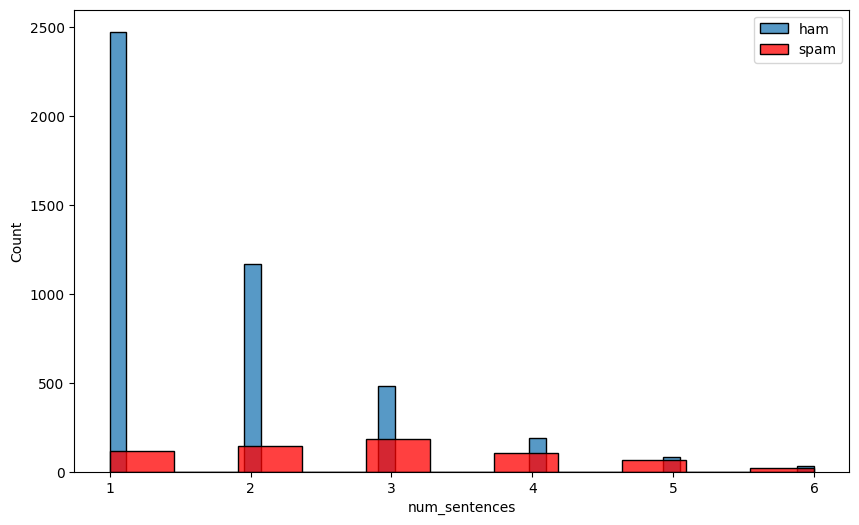

In [64]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data[data['target']==0]['num_sentences'])
ax = sns.histplot(data[data['target']==1]['num_sentences'], color='red')
ax.legend(['ham', 'spam'])

Сравнительные графики

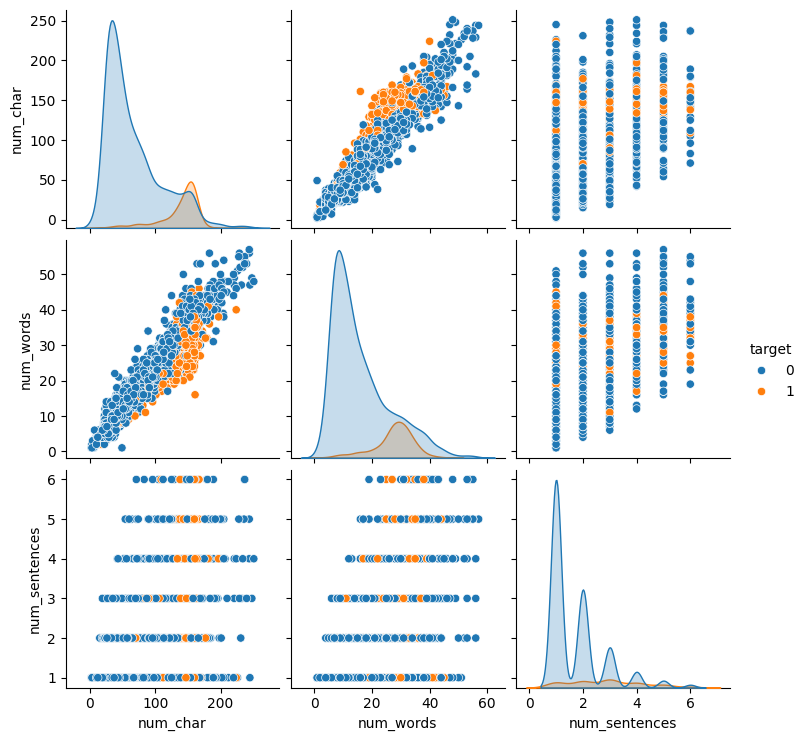

In [65]:
sns.pairplot(data, hue='target')

Корреляционная матрица

<Axes: >

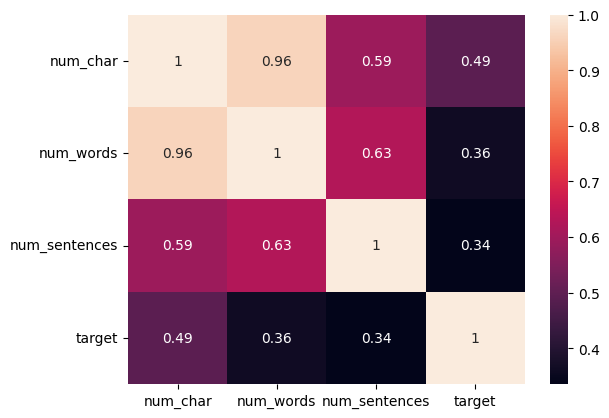

In [66]:
sns.heatmap(data.corr(numeric_only=True),annot=True)

In [67]:
def transform_text(text):
    text = text.lower() # привели к маленьким буквам
    text = nltk.word_tokenize(text) # разбили на токены - слова
    ps = PorterStemmer() # стеммер - оставляет только основы

    # удаление символов
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    # удаление стоп-слов
    for i in text:
        if i not in stopwords.words('english'):
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

Посмотрим как обрабатывается случайное собщение

In [68]:
data['text'][100]

'Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx'

In [69]:
transform_text(data['text'][100])

'okay name ur price long legal wen pick u ave x am xx'

Обрабатываем все сообщения

In [70]:
data['transformed_text'] = data['text'].apply(transform_text)

In [71]:
data.head()

,num_char,num_words,num_sentences,text,target,transformed_text
0,111,24,2,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazi avail bugi n great world...
1,29,8,2,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,155,37,2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entri 2 wkli comp win fa cup final tkt 21...
3,49,13,1,U dun say so early hor... U c already then say...,0,u dun say earli hor u c alreadi say
4,61,15,1,"Nah I don't think he goes to usf, he lives aro...",0,nah think goe usf live around though


Облака слов

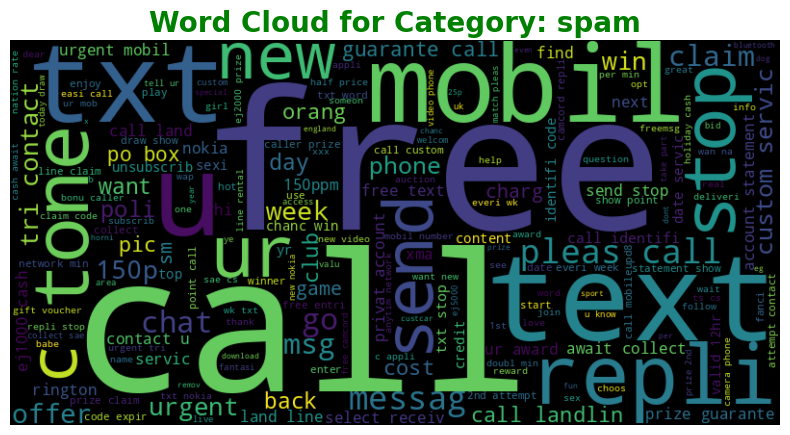

In [72]:
wc = WordCloud(width=800, height=400, min_font_size=5, background_color='black')
spam_wc = wc.generate(data[data['target']==1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear', cmap='viridis')
plt.title(f'Word Cloud for Category: spam', fontsize=20, fontweight='bold', color='green')
plt.axis('off')
plt.show()

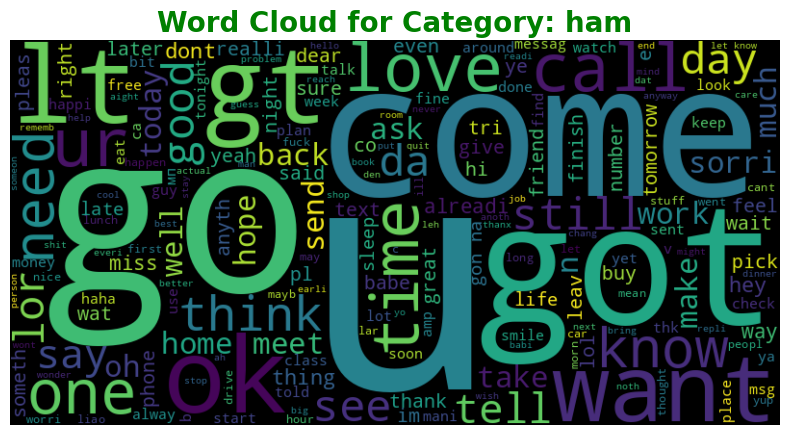

In [73]:
ham_wc = wc.generate(data[data['target']==0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear', cmap='viridis')
plt.title(f'Word Cloud for Category: ham', fontsize=20, fontweight='bold', color='green')
plt.axis('off')
plt.show()

Топ-30 часто встречающихся слов в спаме

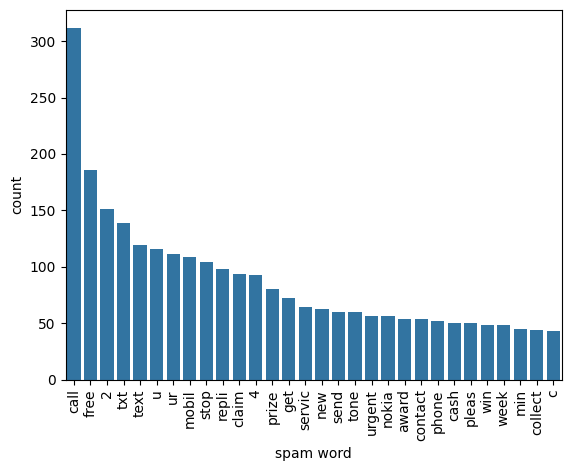

In [74]:
spam_corpus = []
for msg in data[data['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

most_common_words = pd.DataFrame(Counter(spam_corpus).most_common(30), columns=['spam word', 'count'])
sns.barplot(x='spam word', y='count', data=most_common_words)
plt.xticks(rotation=90)
plt.show()

Топ-30 часто встречающихся слов в хаме

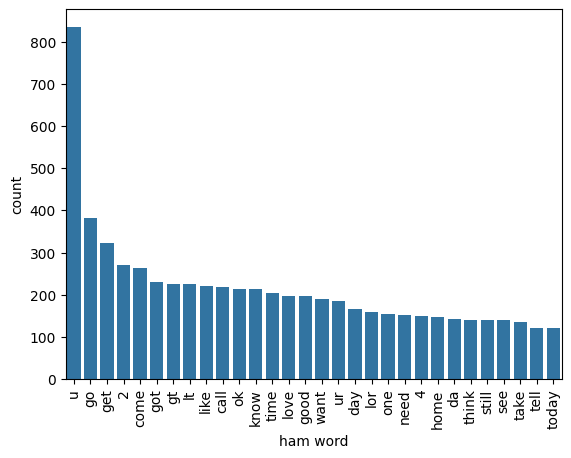

In [75]:
ham_corpus = []
for msg in data[data['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

most_common_words = pd.DataFrame(Counter(ham_corpus).most_common(30), columns=['ham word', 'count'])
sns.barplot(x='ham word', y='count', data=most_common_words)
plt.xticks(rotation=90)
plt.show()

Term Frequency-Inverse Document Frequency (TF-IDF) вычисляет важность каждого слова в документе относительно количества его употреблений в данном документе и во всей коллекции текстов.

TF (Частота термина) обозначает, насколько часто определенное слово появляется в данном документе. Таким образом, TF измеряет важность слова в контексте отдельного документа.

IDF (Обратная частота документа) измеряет, насколько уникально слово является по всей коллекции документов. Слова, которые появляются в большинстве документов, имеют низкое IDF, так как они не вносят большой информационной ценности.

The formula that is used to compute the tf-idf for a term t of a document d in a document set is **tf-idf(t, d) = tf(t, d) * idf(t)**, and the idf is computed as **idf(t) = log [ n / df(t) ] + 1** (if smooth_idf=False), where n is the total number of documents in the document set and df(t) is the document frequency of t; the document frequency is the number of documents in the document set that contain the term t.

In [77]:
tfidf = TfidfVectorizer(max_features=3000)

X = tfidf.fit_transform(data['transformed_text']).toarray() # строки - номера сообщений, столбцы - слова, на пересечении tfidf
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2)

Наивный байесовский классификатор

формула Байеса:\
$P(A|B) = \cfrac{P(B|A)P(A)}{P(B)}$\
A - гипотеза (отражает дейсвтие причин), B - событие\
$P(A)$ - априорная вероятность гипотезы А (безусловная пероятность справедливости гипотезы)\
$P(A|B)$ - вероятность гипотезы А при наступлении события В (апостериорная вероятность)\
$P(B|A)$ - вероятность наступления события В при истинности гипотезы А\
$P(B)$ - полная вероятность наступления события В.\
вытекает из формулы:\
$P(AB) = P(A|B)P(B) = P(B|A)P(A)$\
при несовместных гипотезах:\
$P(B) = \sum_{i=1}^{N}P(B|A_i)P(A_i)$

в контексте машинного обучения формула приобретает вид:\
$P(y_k| X) = \cfrac{P(y_k)P(X|y_k)}{P(X)}$\
$P(y_k| X)$ - апострериорная вероятность принадлежности объектов с признаками Х к классу $y_k$\
$P(X|y_k)$ - вероятность признаков Х при заданном классе $y_k$ (правдоподобие)\
$P(y_k)$ - априорная вероятность принадлежности случайного объекста к классу $y_k$\
$P(X)$ - полная вероятность признаков Х

Считаем, что все признаки независимы, поэтому можем опустить знаменатель (он постоянен). Числитель пропорционален совместной вероятности.
$P(y_k, X) = P(X, y_k) = P(x_1, ... x_n, y_k) = P(x_1 | x_2, ..., x_n, y_k) P(x_2, ..., x_n, y_k) = P(x_1 | x_2, ..., x_n, y_k) P(x_2|x_3, ..., x_n, y_k) P(x_3, ..., x_n, y_k) = ... = P(x_1 | x_2, ..., x_n, y_k) P(x_2|x_3, ..., x_n, y_k)...P(x_n, y_k)P(y_k)$\
Так как признаки независимы\
$P(x_i|x_{i+1}, ...,x_n, y_k) = P(x_i| y_k)$\
$P(y_k|x_1, ..., x_n) \propto P(y_k, x1, ..., x_n) = P(y_k) \prod\limits_{i = 1}^nP(x_i|y_k)$

**Апостериорное правило принятия решения:** из двух решений или выбирают то, которому соответствует большая величина апостериорной вероятности.

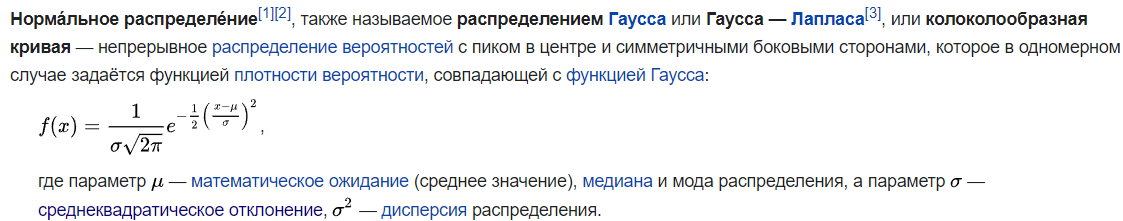



*   Гауссовский наивный байесовский классификатор (GaussianNB) — вариант для работы с непрерывными признаками, которые имеют нормальное (гауссовское) распределение. Вероятность признака при заданном классе вычисляется по формуле:\
gnb.svg\
где $\mu_y$  и $\sigma_y$ — это среднее и стандартное (среднеквадратическое) отклонения признака в классе y. Эти параметры оцениваются с помощью метода максимального правдоподобия по обучающим данным.\
$y = \underset{k∈\{1, ..., K\}}{argmax}P(y_k) \prod\limits_{i = 1}^nP(x_i|y_k)$



In [78]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))

0.8599605522682445


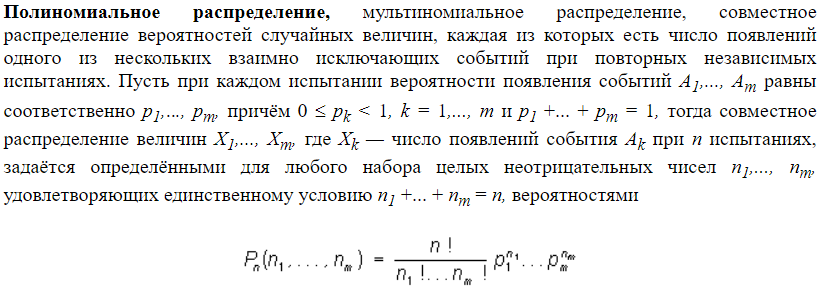



*   Мультиномиальный наивный байесовский классификатор (MultinomialNB) — вариант для работы с дискретными признаками, которые имеют мультиномиальное распределение. Вероятность признака при заданном классе вычисляется по формуле:\
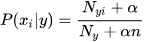\
где $N_{yi}$ — это количество раз, когда признак i встречается в классе y; $N_y$ — общее количество всех признаков в классе y; n — количество различных признаков; а $\alpha$ — сглаживающий параметр, предотвращающий возникновение нулевых вероятностей (default=1.0).\
$y = \underset{k∈\{1, ..., K\}}{argmax}P(y_k) \prod\limits_{i = 1}^nP(x_i|y_k)^{x_i}$


In [79]:
mnb = MultinomialNB()

mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))

0.97534516765286
